# Análisis de los datos recopilados durante el Experimento 1

## Conexto del experimento y de los datos a analizar.

Dentro de este experimento se busca validar las ideas de arquitectura relacionadas con  la implementacion de la táctica de _Recuperación de Fallas_  para favorecer  la disponibilidad mediante a traves de la estrategía de _Retry_ o reintento, por otro lado hemos implementado escalamiento horizontal al agregar 2 instancias más de *gestión de accionables*. Se ha configurado nginx como API Gateway, donde se realiza hasta un máximo de 5 reintentos de la petición en caso de que la petición falle 5 veces se retorna un error 500 al cliente.

Para efectos del experimento generamos valores randomicos dentro de este conjunto [0.0, 1.0) en cada una de las peticiones, esto simulan el comportamiento defectuoso que pueda tener el sistema para responder a una request. Si el valor generado es menor a 0.25 (umbral o threshold) la petición se considera fallida, de lo contrario se considera exitosa. 

_Antececentes_ 

Hemos probado una primera versión de la arquitectura con un solo nodo de *gestión de accionables*, sin la implementación de la táctica de _Recuperación de Fallas_ y los resultados fueron los siguientes:

- 68% de las peticiones fueron fallidas

Puede que exista un factor que sesgue el resultado de lo mencionado en este parrafo, ya que el valor de threshold era de 0.5 y no de 0.25 como en el experimento actual.

###  Datos a analizar

*id* - Un valor uuid que identifica de forma única a cada petición.


*start* - La fecha y hora en la que se realizó la petición.


*end* - La fecha y hora en la que se recibió la respuesta.


*delta* - Tiempo de procesamiento en milisegundos.


*status* - El estado de la petición, si fue procesada correctamente o no. (True/False)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Cargar los datos de los requests de entrada y las respuestas de salida

In [18]:
input = pd.read_csv("../services/unidad_monitoreo/input.csv")
responses = pd.read_csv("../services/gestion_accionables/responses.csv",  names=['id', 'start', 'end', 'delta', 'status'])

## Requests de entrada generados en la Unidad de monitoreo vs Request recibidas por el módulo gestión de accionables

In [19]:
total_input_requests = input['id'].unique().size
total_received_requests_uuid = responses['id'].unique().size

### Logs de los requests de entrada generados en la Unidad de monitoreo

In [20]:
input.head()

,id,start,end,delta,status
0,9ae82d67-0327-4d61-b50e-9f61690c885b,2022-09-11T15:23:05.520226,2022-09-11T15:23:05.529590,9364,True
1,af1b0e4a-98e5-4469-81b0-1c1d6391ff56,2022-09-11T15:23:05.830987,2022-09-11T15:23:05.841803,10816,True
2,7e301ab2-7738-49d8-87fb-a8b7880568f6,2022-09-11T15:23:06.143918,2022-09-11T15:23:06.158013,14095,True
3,111f5ff8-4bdf-4b0e-bffe-cab7a689466b,2022-09-11T15:23:06.459330,2022-09-11T15:23:06.482717,23387,True
4,5162992b-0ffa-47fd-b83c-38a594b27c8d,2022-09-11T15:23:06.784153,2022-09-11T15:23:06.800086,15933,True


### Logs de los requests recibidos por el módulo gestión de accionables

In [21]:
responses.head()

,id,start,end,delta,status
0,9ae82d67-0327-4d61-b50e-9f61690c885b,2022-09-11T15:23:05.525232,2022-09-11T15:23:05.525306,74,True
1,af1b0e4a-98e5-4469-81b0-1c1d6391ff56,2022-09-11T15:23:05.836381,2022-09-11T15:23:05.836499,118,True
2,7e301ab2-7738-49d8-87fb-a8b7880568f6,2022-09-11T15:23:06.150876,2022-09-11T15:23:06.150996,120,True
3,111f5ff8-4bdf-4b0e-bffe-cab7a689466b,2022-09-11T15:23:06.467079,2022-09-11T15:23:06.467264,185,False
4,111f5ff8-4bdf-4b0e-bffe-cab7a689466b,2022-09-11T15:23:06.474811,2022-09-11T15:23:06.474997,186,True


In [22]:
respuestas = pd.DataFrame({ 'total': [total_input_requests, total_received_requests_uuid] }, index=['total_input_requests', 'total_requests_processed'])
respuestas


,total
total_input_requests,100
total_requests_processed,100


<AxesSubplot:title={'center':'Input requests vs requests processed'}>

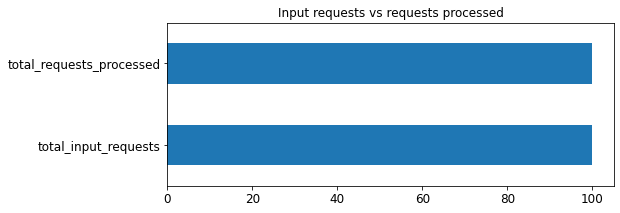

In [23]:
respuestas.plot(kind='barh', title='Input requests vs requests processed', figsize=(8, 3), legend=False, fontsize=12)

De acuerdo a estos datos descibe que de un total de 100 solicitudes de entrada, 100 fueron recibidas por el módulo gestión de accionables. Esto quiere decir que no hubo ninguna solicitud de entrada que no haya sido recibida por el módulo gestión de accionables.

## Solicitudes procesadas exitosamente vs Solicitudes no procesadas

In [24]:
responses_successfully = responses[responses['status'] == True]['id'].unique().size
responses_failed = total_received_requests_uuid - responses_successfully

<AxesSubplot:title={'center':'Succesful vs Fail'}>

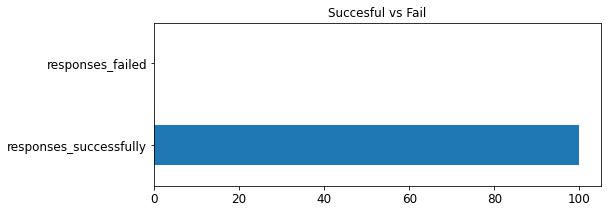

In [25]:
# Graficar los resultados en un grafico de barras horizontal
resultados = pd.DataFrame({ 'total': [responses_successfully, responses_failed] }, index=['responses_successfully', 'responses_failed'])
resultados.plot(kind='barh', title='Succesful vs Fail', figsize=(8, 3), legend=False, fontsize=12)

Deacuerdo a esta grafica, obsevamos que de un total de 100 solicitudes de entrada, 100 fueron procesadas exitosamente. Esto quiere decir que no hubo ninguna solicitud de entrada que no haya sido procesada exitosamente por el módulo gestión de accionables.

## Solicitudes totales generadas vs Solicitudes totales procesadas

Dentro de este apartado se muestra la cantidad de solicitudes totales generadas por la unidad de monitoreo vs solicitudes totales procesadas por la gestión de accionables sin importar si fueron exitosas o fallidas en el experimento. Ya que aqui están incluidas las solicitudes que fueron reintentadas.

In [26]:
all_received_requests = responses['id'].size

<AxesSubplot:title={'center':'All received requests vs total input requests'}>

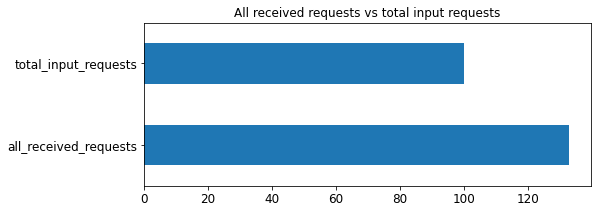

In [28]:
all_requests = pd.DataFrame({ 'total': [all_received_requests, total_input_requests] }, index=['all_received_requests', 'total_input_requests'])
all_requests.plot(kind='barh', title='All received requests vs total input requests', figsize=(8, 3), legend=False, fontsize=12)

La gráfica representa que la _gestión de accionables_ procesó 133 solicitudes, a partir de 100 solicitudes generadas por la unidad de monitoreo. Esto quiere decir que hubo 33 solicitudes que fueron reintentadas, eso deducción es válida si y solo si con antelación sabemos el número de solicitudes fueron procesadas exitosamente: es ahí donde nos ayudamos de gráfica anterior donde nos dice que 100 solicitudes fueron procesadas exitosamente y 0 fueron fallidas luego de los reintentos.

## Medir los reintentos de las solicitudes

<AxesSubplot:title={'center':'Reintentos'}, ylabel='Frequency'>

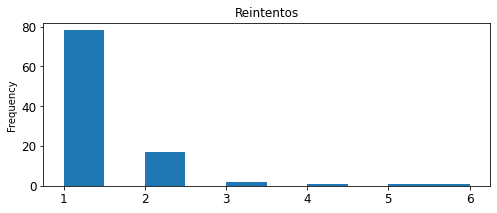

In [ ]:
reintentos = responses.groupby('id').size().reset_index(name='reintentos')
reintentos.plot(kind='hist', title='Reintentos', figsize=(8, 3), legend=False, fontsize=12)

<AxesSubplot:title={'center':'Reintentos'}, ylabel='reintentos'>

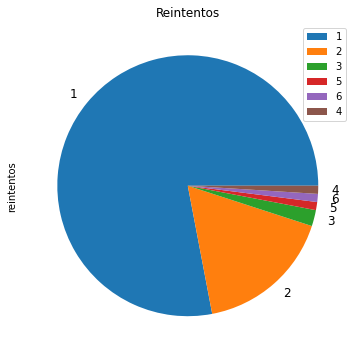

In [32]:
# grafico de pie de los reintentos
reintentos['reintentos'].value_counts().plot(kind='pie', title='Reintentos', figsize=(6, 6), legend=True, fontsize=12)

La _sección 1_ de la gráfica nos muestra que de un total de 100 solicitudes, 79% solicitudes fueron procesadas exitosamente en la primera vez, mientras que 21% solicitudes fueron procesadas exitosamente mediante máximo 5 reintentos más, que valida el uso de la táctica de _Recuperación de Fallas_ en la arquitectura.